# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [01:06<00:00, 903File/s]  


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

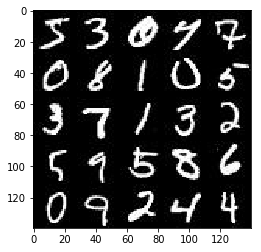

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

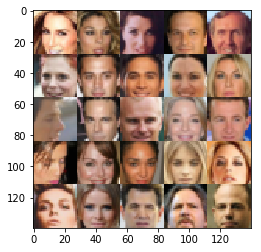

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, ())
    return inputs, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [41]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Here is the PRelu slope
    alpha = 0.2
    n_filters=[64, 128]
    h = images
    with tf.variable_scope('discriminator', reuse=reuse):
        for layer_i, n_output in enumerate(n_filters):
            h = tf.layers.conv2d(h, n_output, 3, strides=2, padding='same')
            h = tf.maximum(alpha * h, h)
            
        # Get the dimensions for flatten afterwards
        dims = h.get_shape().as_list()
        flattened = tf.reshape(h, shape=[-1, dims[1] * dims[2] * dims[3]])
        logits = tf.layers.dense(flattened, 1)
        out = tf.sigmoid(logits)
        
        # print the last second dimension
        print('the last second dimension of discriminator is :', dims)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

the last second dimension of discriminator is : [None, 7, 7, 128]
the last second dimension of discriminator is : [None, 7, 7, 128]
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [42]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    n_filters=[128, 64]
    n_filters.append(out_channel_dim)
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        # Here I match the input size using the last second layer of discriminator
        h = tf.layers.dense(z, 7*7*n_filters[0])
        h = tf.reshape(h, (-1, 7, 7, n_filters[0]))
        h = tf.layers.batch_normalization(h, training=is_train)
        h = tf.maximum(alpha * h, h)
        
        for layer_i, n_output in enumerate(n_filters[1:-1]):
            h = tf.layers.conv2d_transpose(h, n_output, 3, strides=2, padding='same')
            h = tf.layers.batch_normalization(h, training=is_train)
            h = tf.maximum(alpha * h, h)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h, n_filters[-1], 3, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [43]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # the discriminator is shared between real data and fake data
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # The discriminator tries to have a task like classification
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, 
            labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    # the aim of generator is to confuse the discriminator for simulated fake data
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, 
            labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

the last second dimension of discriminator is : [None, 7, 7, 128]
the last second dimension of discriminator is : [None, 7, 7, 128]
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [44]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    samples, losses = [], []
    print_every = 10
    show_every = 100
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images, 
                    input_z: batch_z, 
                    lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z, 
                    input_real: batch_images, 
                    lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

the last second dimension of discriminator is : [None, 7, 7, 128]
the last second dimension of discriminator is : [None, 7, 7, 128]
Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 0.6437
Epoch 1/2... Discriminator Loss: 1.1135... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 0.7119
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 0.9062... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 0.8190... Generator Loss: 1.0458
Epoch 1/2... Discriminator Loss: 0.7784... Generator Loss: 1.1174
Epoch 1/2... Discriminator Loss: 0.7450... Generator Loss: 1.1882
Epoch 1/2... Discriminator Loss: 0.7345... Generator Loss: 1.2242


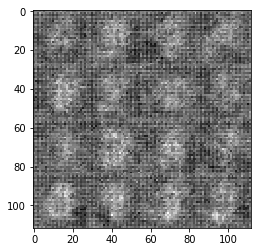

Epoch 1/2... Discriminator Loss: 0.7331... Generator Loss: 1.2291
Epoch 1/2... Discriminator Loss: 0.7129... Generator Loss: 1.3386
Epoch 1/2... Discriminator Loss: 0.7059... Generator Loss: 1.3362
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.5411
Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 1.2968
Epoch 1/2... Discriminator Loss: 0.7367... Generator Loss: 1.4335
Epoch 1/2... Discriminator Loss: 0.7393... Generator Loss: 1.3860
Epoch 1/2... Discriminator Loss: 0.7755... Generator Loss: 1.2095
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.3180
Epoch 1/2... Discriminator Loss: 0.7663... Generator Loss: 1.4622


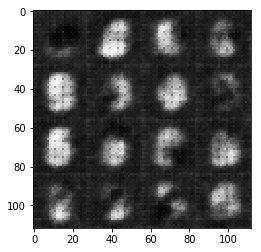

Epoch 1/2... Discriminator Loss: 0.8309... Generator Loss: 1.2762
Epoch 1/2... Discriminator Loss: 0.7884... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 1.1525
Epoch 1/2... Discriminator Loss: 0.8329... Generator Loss: 1.2155
Epoch 1/2... Discriminator Loss: 0.7330... Generator Loss: 1.4696
Epoch 1/2... Discriminator Loss: 0.7423... Generator Loss: 1.6207
Epoch 1/2... Discriminator Loss: 0.7960... Generator Loss: 1.3698
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 1.5824
Epoch 1/2... Discriminator Loss: 0.7981... Generator Loss: 1.2235
Epoch 1/2... Discriminator Loss: 0.7721... Generator Loss: 1.5377


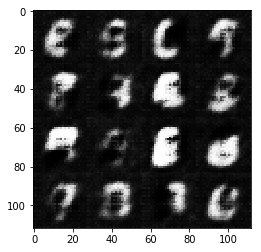

Epoch 1/2... Discriminator Loss: 0.7757... Generator Loss: 1.3961
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.1769
Epoch 1/2... Discriminator Loss: 0.7911... Generator Loss: 1.4072
Epoch 1/2... Discriminator Loss: 0.7623... Generator Loss: 1.5204
Epoch 1/2... Discriminator Loss: 0.7536... Generator Loss: 1.6368
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 1.2949
Epoch 1/2... Discriminator Loss: 0.7666... Generator Loss: 1.5436
Epoch 1/2... Discriminator Loss: 0.7839... Generator Loss: 1.3014
Epoch 1/2... Discriminator Loss: 0.8282... Generator Loss: 1.2742
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 1.1983


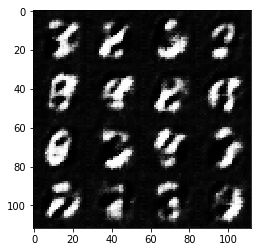

Epoch 1/2... Discriminator Loss: 0.8912... Generator Loss: 1.4446
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 1.2571
Epoch 1/2... Discriminator Loss: 0.8933... Generator Loss: 1.3786
Epoch 1/2... Discriminator Loss: 0.9054... Generator Loss: 1.2809
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 1.3393
Epoch 1/2... Discriminator Loss: 0.9555... Generator Loss: 1.1812
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 1.4300
Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 1.1707
Epoch 1/2... Discriminator Loss: 1.0115... Generator Loss: 1.3050
Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 1.1742


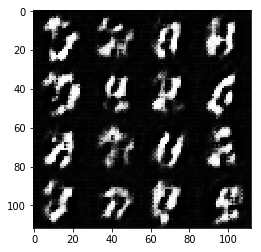

Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 1.3373
Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 1.2669
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.1367
Epoch 1/2... Discriminator Loss: 1.1006... Generator Loss: 1.2048
Epoch 1/2... Discriminator Loss: 1.1156... Generator Loss: 0.9599
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 1.2312
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 0.9576
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 0.9270


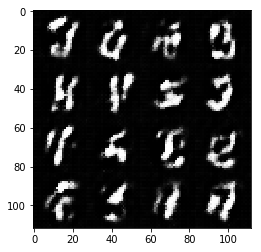

Epoch 1/2... Discriminator Loss: 1.1467... Generator Loss: 0.8758
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 0.9857
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 1.3235
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 1.0329
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 1.0027
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.8485
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 1.1470
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 0.9187
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 1.0301
Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 0.9592


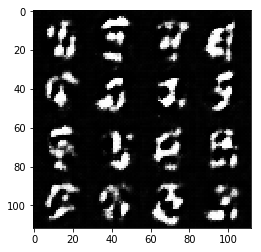

Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 1.1947
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 1.2287
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.9229
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 1.2785
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.9182
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 1.0643
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.8763


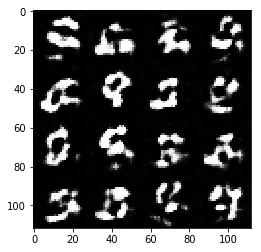

Epoch 1/2... Discriminator Loss: 1.1869... Generator Loss: 0.9858
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 1.0064
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 1.0480
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.8467
Epoch 1/2... Discriminator Loss: 1.1736... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.8035
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 0.8551


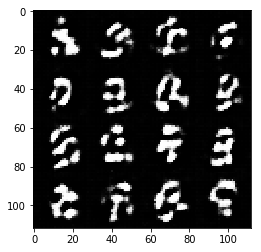

Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 1.0172
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 1.1141
Epoch 1/2... Discriminator Loss: 1.2340... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.8955
Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 1.2776... Generator Loss: 0.7288
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.9378
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.7723
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.9095
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.8822


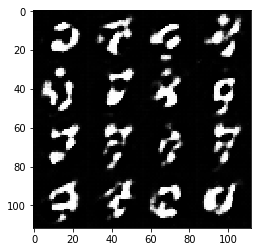

Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.8263
Epoch 2/2... Discriminator Loss: 1.1923... Generator Loss: 1.0122
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 1.3178... Generator Loss: 0.8649
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.8414
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.8348
Epoch 2/2... Discriminator Loss: 1.2683... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.2500... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.7671


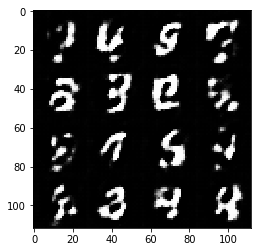

Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 0.9602
Epoch 2/2... Discriminator Loss: 1.2747... Generator Loss: 0.8459
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 1.2850... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.9712
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.8787
Epoch 2/2... Discriminator Loss: 1.2922... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 1.2410... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 1.2419... Generator Loss: 0.8237


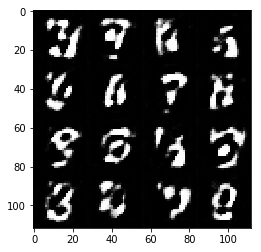

Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 0.9531
Epoch 2/2... Discriminator Loss: 1.2984... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.8637
Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.8162
Epoch 2/2... Discriminator Loss: 1.2912... Generator Loss: 0.9936
Epoch 2/2... Discriminator Loss: 1.3083... Generator Loss: 1.0279
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 1.0215
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 0.8687
Epoch 2/2... Discriminator Loss: 1.2867... Generator Loss: 0.8661
Epoch 2/2... Discriminator Loss: 1.3238... Generator Loss: 0.8310


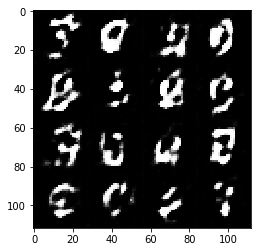

Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 1.3850... Generator Loss: 0.9675
Epoch 2/2... Discriminator Loss: 1.3012... Generator Loss: 1.0616
Epoch 2/2... Discriminator Loss: 1.3076... Generator Loss: 0.7969
Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 0.9083
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.8180
Epoch 2/2... Discriminator Loss: 1.2951... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 1.2979... Generator Loss: 0.9339
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 0.7707


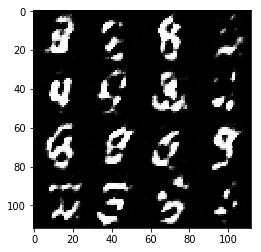

Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 1.0767
Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 0.8262
Epoch 2/2... Discriminator Loss: 1.2898... Generator Loss: 0.8600
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.8650
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.8043
Epoch 2/2... Discriminator Loss: 1.3849... Generator Loss: 1.0160
Epoch 2/2... Discriminator Loss: 1.2988... Generator Loss: 0.9506
Epoch 2/2... Discriminator Loss: 1.3087... Generator Loss: 0.7874
Epoch 2/2... Discriminator Loss: 1.3120... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 1.2598... Generator Loss: 0.8702


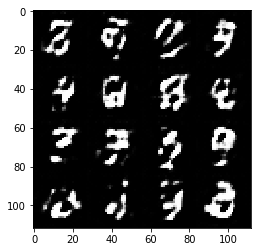

Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.8673
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.2662... Generator Loss: 1.0442
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.3013... Generator Loss: 0.9981
Epoch 2/2... Discriminator Loss: 1.3114... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.3167... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 1.0995
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.8472


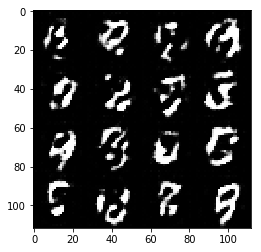

Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.8682
Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 0.9475
Epoch 2/2... Discriminator Loss: 1.2505... Generator Loss: 0.7844
Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.8312
Epoch 2/2... Discriminator Loss: 1.3054... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.9476
Epoch 2/2... Discriminator Loss: 1.2885... Generator Loss: 0.8878
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.9407
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.8549
Epoch 2/2... Discriminator Loss: 1.3514... Generator Loss: 1.0960


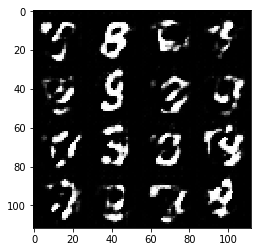

Epoch 2/2... Discriminator Loss: 1.2906... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 1.2995... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.8307
Epoch 2/2... Discriminator Loss: 1.3324... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.9677
Epoch 2/2... Discriminator Loss: 1.2962... Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 1.3109... Generator Loss: 0.7437
Epoch 2/2... Discriminator Loss: 1.1832... Generator Loss: 0.9873
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 0.9828


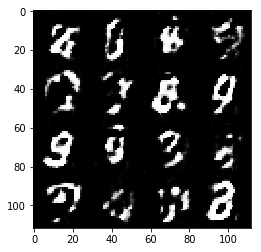

Epoch 2/2... Discriminator Loss: 1.3485... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 1.1496
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.7225
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.8814
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.9853
Epoch 2/2... Discriminator Loss: 1.2965... Generator Loss: 0.9036


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

the last second dimension of discriminator is : [None, 7, 7, 128]
the last second dimension of discriminator is : [None, 7, 7, 128]
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.0643... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.0771
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.1722
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.2645


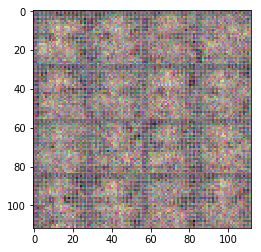

Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.3155
Epoch 1/1... Discriminator Loss: 0.8882... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 1.0247
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9133
Epoch 1/1... Discriminator Loss: 1.2076... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9481


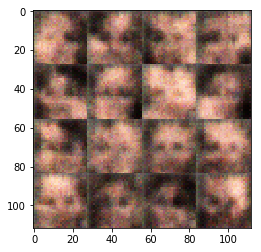

Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.8813
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.8820
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.8939


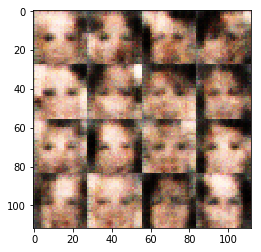

Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.9431
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.8291


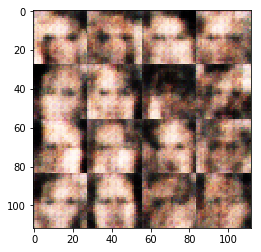

Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8325
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8957


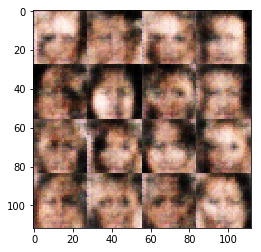

Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.3144... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8526


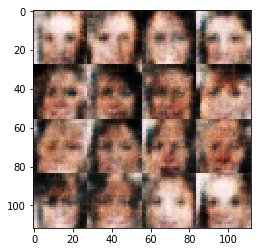

Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.8029


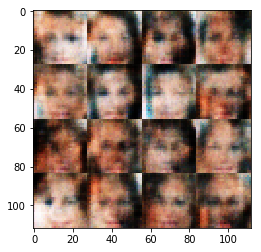

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8307


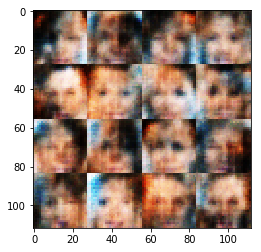

Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.8478
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.8357
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7678


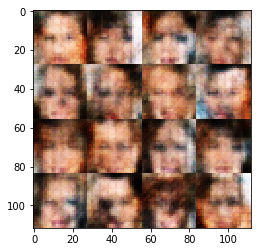

Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.8114


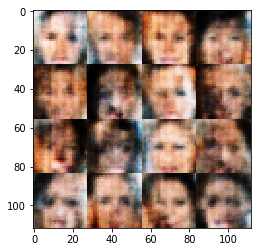

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8053


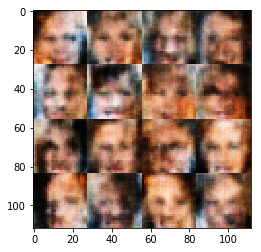

Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7970


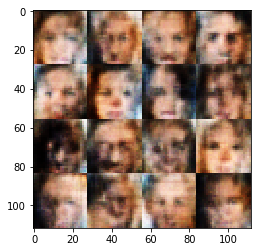

Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.8333


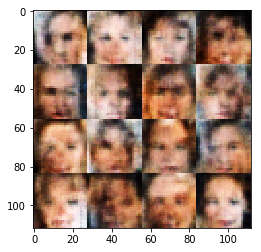

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8359


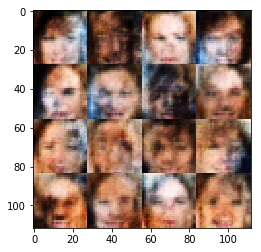

Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7850


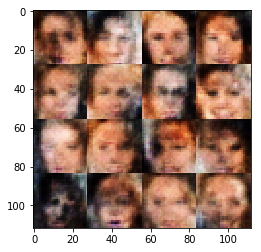

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7925


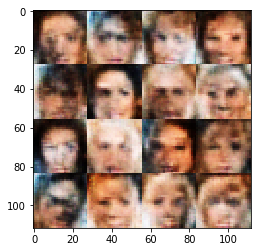

Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7871


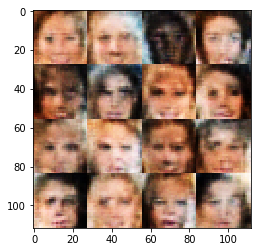

Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7855


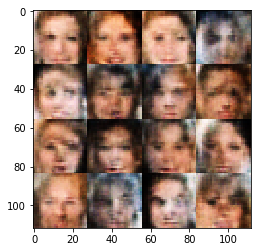

Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8064


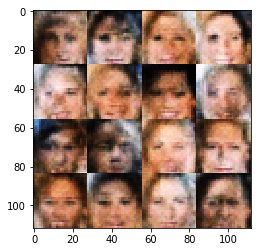

Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8088


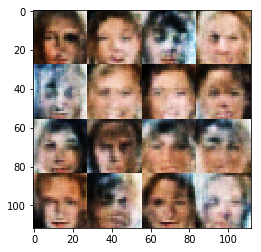

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7625


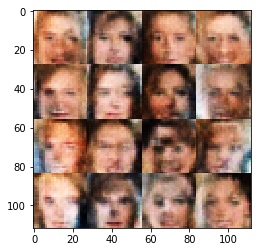

Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8335


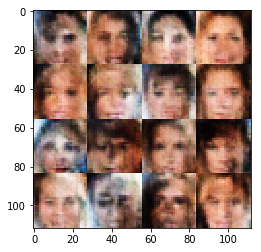

Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7803


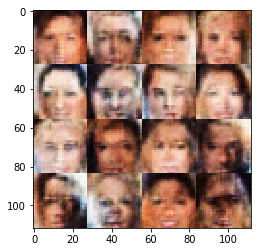

Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8181


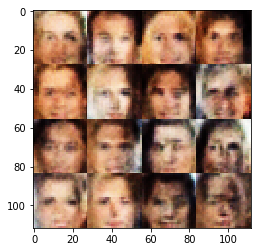

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8318
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.8346


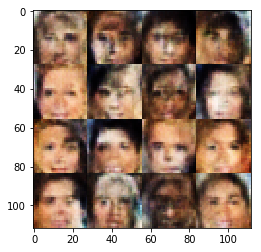

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8111
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.8222


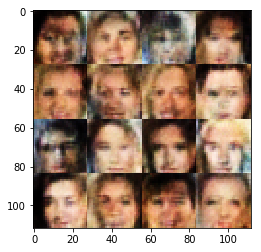

Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7949


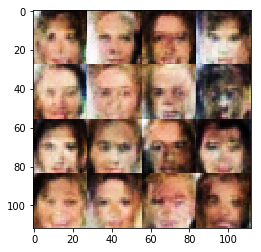

Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8075


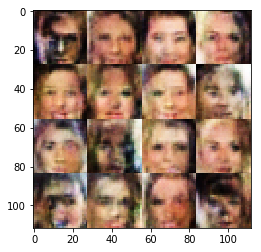

Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.8205


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.